## Importing Library and Data

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

In [33]:
df = pd.read_csv("../input/time-series-datasets/Electric_Production.csv",index_col='DATE', parse_dates=True)
df.columns = ["Production"]
df.head()

,Production
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [34]:
df.isnull().sum()

Production    0
dtype: int64

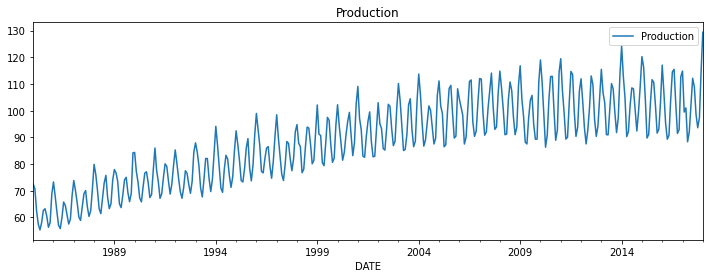

In [35]:
df.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Production')
plt.show(block=False)

## Time Series Decomposition

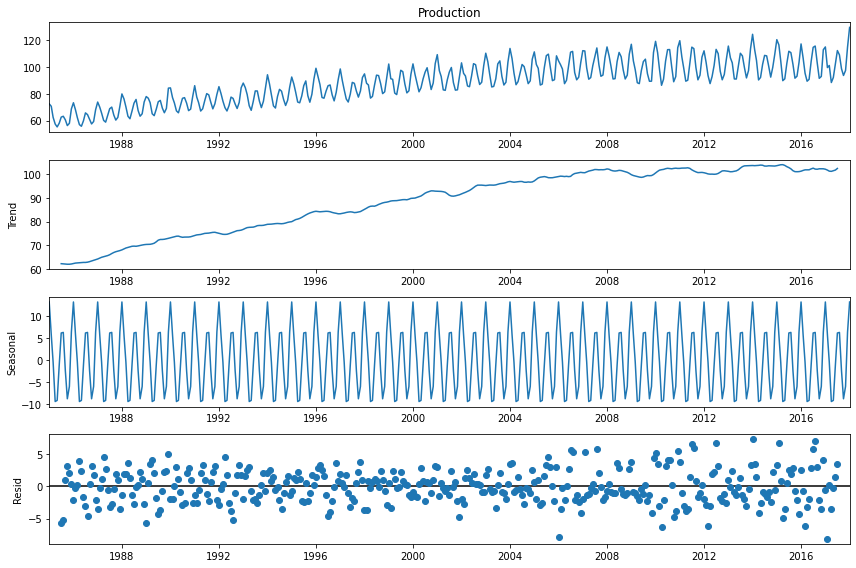

In [36]:
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(df.Production)
fig = decomposition.plot()
plt.show()

**Looking at the above plot we can see the trend in the Time Series.**

## Data Preparation

In [37]:
train_len = 360
train=df[0:train_len]
test=df[train_len:] 
print("Training set: ", train.shape)
print("Testing set: ", test.shape)

Training set:  (360, 1)
Testing set:  (37, 1)


In [38]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [39]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [40]:
n_months = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_months, batch_size=1)

## Model-LSTM

In [41]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', input_shape=(n_months, 1)),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = model.fit(generator, epochs=10)

Epoch 1/10
348/348 [==============================] - 4s 7ms/step - loss: 0.0255
Epoch 2/10
348/348 [==============================] - 3s 7ms/step - loss: 0.0150
Epoch 3/10
348/348 [==============================] - 2s 7ms/step - loss: 0.0129
Epoch 4/10
348/348 [==============================] - 2s 7ms/step - loss: 0.0104
Epoch 5/10
348/348 [==============================] - 2s 7ms/step - loss: 0.0059
Epoch 6/10
348/348 [==============================] - 2s 7ms/step - loss: 0.0041
Epoch 7/10
348/348 [==============================] - 2s 7ms/step - loss: 0.0036
Epoch 8/10
348/348 [==============================] - 3s 7ms/step - loss: 0.0026
Epoch 9/10
348/348 [==============================] - 3s 8ms/step - loss: 0.0026
Epoch 10/10
348/348 [==============================] - 2s 7ms/step - loss: 0.0023


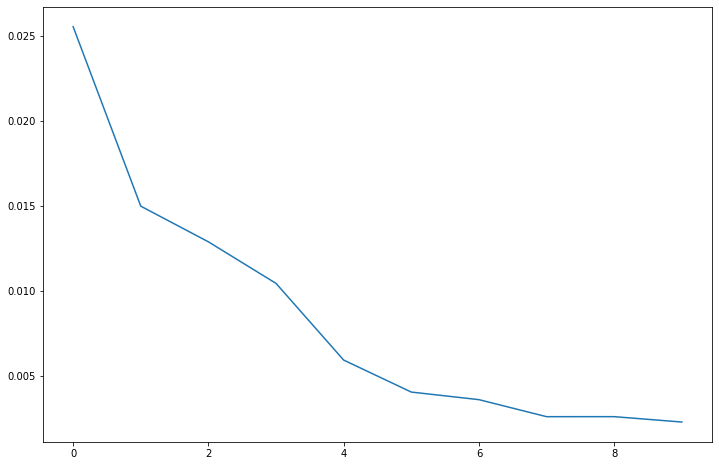

In [43]:
plt.plot(history.history['loss'])
plt.show()

## Model Evaluation

In [44]:
temp = scaled_train[-n_months:]
temp = temp.reshape((1, n_months, 1))
model.predict(temp)

array([[0.89111996]], dtype=float32)

In [45]:
test_predictions = []
last_batch = scaled_train[-n_months:]
current_batch = last_batch.reshape((1, n_months, 1))
for i in range((test.shape[0])):
    pred = model.predict(current_batch)[0]
    test_predictions.append(pred)
    current_batch = np.append(current_batch[:, 1:, :], [[pred]], axis=1)

In [46]:
test['LSTM_Predictions'] = scaler.inverse_transform(test_predictions)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


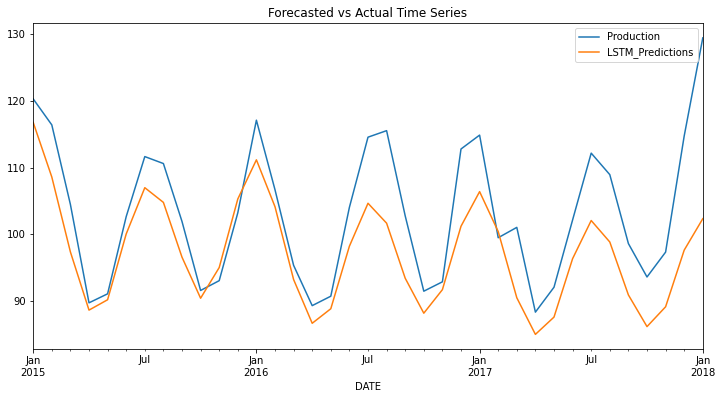

In [47]:
test.plot(figsize=(12,6))
plt.title("Forecasted vs Actual Time Series")
plt.show()

In [48]:
test.head(10)

,Production,LSTM_Predictions
DATE,,
2015-01-01,120.2696,116.748732
2015-02-01,116.3788,108.579596
2015-03-01,104.4706,97.364890
2015-04-01,89.7461,88.655967
2015-05-01,91.0930,90.206539
2015-06-01,102.6495,100.053911
2015-07-01,111.6354,106.979644
2015-08-01,110.5925,104.778176
2015-09-01,101.9204,96.576151
